In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tables

# SIMF

Load the `simf` module.

In [2]:
from simf import *
from simf.common import split_streams, build_test_set, build_sparse_matrix

## Load data

Read *yelp* data on *users*, *bars*, *hotels* and *restaurants*.

The data covers the period from 2.7.2017 to 2.7.2018.

In [3]:
with tables.open_file('data/yelp_users-restaurants.tbl', 'r') as h5_file:
    s1 = h5_file.root.data.read()
with tables.open_file('data/yelp_users-bars.tbl', 'r') as h5_file:
    s2 = h5_file.root.data.read()
with tables.open_file('data/yelp_users-hotels.tbl', 'r') as h5_file:
    s3 = h5_file.root.data.read()

# Create data streams
train_ur, train_ub, train_uh, test_ur, test_ub, test_uh = split_streams([s1, s2, s3], t=1508546800)
test_set = build_test_set(test_ur)

# Create object types
o_users = ObjectType('users', 25)
o_restaurants = ObjectType('restaurants', 10)
o_bars = ObjectType('bars', 10)
o_hotels = ObjectType('hotels', 10)

Data is encoded in sparse format, and includes:
* row
* column
* value
* timestamp

For example, let's look at stream 1:

In [4]:
s1.shape

(4, 589772)

There are 21936 data points. Let's look at the first three entries:

In [5]:
s1[:,:3]

array([[         0,          1,          1],
       [         0,          1,          2],
       [         4,          4,          5],
       [1505772000, 1505772000, 1505772000]], dtype=int32)

The data is divided into the pretraining (from 2.7.2017 to 20.10.2017) and streaming set (from 21.10.2017 to 2.7.2018). The split date is set when calling the `split_streams` function with parameter `t=1508546800`.

## Pretraining

In [6]:
def pre_train_models(models, relations, streams):
    main_relation = relations[0]
    test_set = build_test_set(streams[0])
    # Iterate through models
    for m_name, m in models.items():
        print(m_name)
        data = [main_relation]  # data is just one stream (main relation)
        if "X3" in m_name:
            # data is composed of all three streams (main relation + two auxiliary relations)
            data = relations
        # Fit models
        m.fit(data=data, verbose=True)
        # Calculate the error (train and test - remaining stream)
        print("Train error: RMSE:%f,  MAE:%f" % m.get_train_error()[main_relation])
        print("Test error: RMSE:%f,  MAE:%f\n" % m.get_test_error(main_relation, test_set)[main_relation])
    print("Initial factorization complete")
    return models

## Streaming phase

In [7]:
def evaluate_stream(models, relations, streams, update_interval=3600, max_iter=3, max_updates=None):
    r1, r2, r3 = relations
    results = {}
    # Update models with new params
    for n, m in models.items():
        m.max_iter = max_iter
    print("Starting streaming phase")
    for k, s in enumerate(streams):
        streams[k] = list([
            [int(x) for x in s[0]],
            [int(x) for x in s[1]],
            [float(x) for x in s[2]],
            [int(x) for x in s[3]]]
        )
    # Sliding windows of stream data - discrete intervals [current_ts, next_ts]
    current_ts = streams[0][3][0]
    next_ts = current_ts + update_interval
    windows = [[] for k in streams]

    i = 0
    # End when main stream runs out of instances
    while len(streams[0][3]) > 0:
        if max_updates and i >= max_updates:
            break
        row, col, val, ts = [], [], [], []
        # Pop elements into the window
        for k, s in enumerate(streams):
            while len(s[3]) > 0 and s[3][0] <= next_ts:
                row.append(s[0].pop(0))
                col.append(s[1].pop(0))
                val.append(s[2].pop(0))
                ts.append(s[3].pop(0))
            windows[k] = [row, col, val, ts]
            row, col, val, ts = [], [], [], []

        # Continue with next window if no updates on main relation
        if float(len(windows[0][0])) < 1:
            current_ts += update_interval
            next_ts += update_interval
            continue
        # Get true values from the main stream
        true_values = np.array(windows[0][2])
        average_rmse = None

        if i % 25 == 0:
            print()
            print("Window: ", i, current_ts, next_ts)
        # Loop through all models
        for m_name, m in models.items():
            # Get predictions for the current window
            predictions = m.predict_stream(r1, list(zip(*windows[0][:3])), verbose=False)
            # Get the error of the average predictor (for calculating rrmse)
            if m_name == 'Average':
                average_rmse = m.rmse(true_values, predictions)
            # Get the error for other predictors and calculate the rrmse
            mrmse = m.rmse(true_values, predictions)
            rrmse = mrmse / average_rmse
            if i % 25 == 0:
                print("%s window error: RMSE:%f,  RRMSE:%f" % (m_name, mrmse, rrmse))
            # Append results
            if m_name not in results:
                results[m_name] = ([mrmse], [rrmse])
            else:
                results[m_name][0].append(mrmse)
                results[m_name][1].append(rrmse)

            # Update models
            r1.set_matrix(build_sparse_matrix(windows[0][:3]))
            r2.set_matrix(build_sparse_matrix(windows[1][:3]))
            r3.set_matrix(build_sparse_matrix(windows[2][:3]))
            data = [r1]  # data is just one stream (main relation)
            if "X3" in m_name:
                # data is composed of all three streams (main relation + two auxiliary relations)
                data = [r1, r2, r3]
            m.fit_update(data=data, verbose=False)

        # Update the interval
        current_ts += update_interval
        next_ts += update_interval
        i += 1
    return results

In [8]:
def plot_results(results, plot_rrmse=True, l=0.99, title='', save_to_file=None, ylim=None):
    plt.figure(figsize=(10, 5))
    for name, res in results.items():
        rrmses = res[int(plot_rrmse)]
        preq_errors = []
        si = 0
        ni = 0
        mdata = np.array(rrmses)
        for r in mdata:
            r = float(r)
            si = r + l * si
            ni = 1 + l * ni
            preq_errors.append(si / float(ni))
        plt.plot(range(len(preq_errors)), preq_errors, label=name)

    if ylim:
        plt.ylim(ylim)

    plt.ylabel('Prequential RRMSE')
    plt.xlabel('Instances (Updates)')
    plt.title(title)
    plt.legend()
    plt.show()
    if save_to_file:
        plt.savefig(save_to_file, bbox_inches='tight')

# Two examples

## Recommending *restaurants*

### Pick models to test

In [9]:
models = {
    'Average': Average(),
    'RMF': RMF(rank=25, max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF_X3': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF_X3_CB': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008, combine_bias=True),
}

r_ur = Relation(o_users, o_restaurants, build_sparse_matrix(train_ur), weight=1)
r_ub = Relation(o_users, o_bars, build_sparse_matrix(train_ub), weight=1)
r_uh = Relation(o_users, o_hotels, build_sparse_matrix(train_uh), weight=1)

Init random seed for consistent results.

In [10]:
np.random.seed(42)

### Initial factorization

In [11]:
models = pre_train_models(models, [r_ur, r_ub, r_uh], [test_ur, test_ub, test_uh])

Average
2019-04-15 14:36:37,596: Fitting the average model: bias=True, update=True
2019-04-15 14:36:37,628: Fit complete in 0.030705928802490234 seconds
Train error: RMSE:1.240055,  MAE:1.025735
Test error: RMSE:1.400745,  MAE:1.165995

RMF
2019-04-15 14:36:39,797: Initialization complete in 0.10239219665527344 seconds
2019-04-15 14:36:39,798: Factorizing (SGD) 1 relations: bias=True, max_iter=20, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 14:37:04,639: Factorization complete in 24.944637060165405 seconds
Train error: RMSE:0.855502,  MAE:0.672108
Test error: RMSE:1.396186,  MAE:1.163119

SIMF
2019-04-15 14:37:08,579: Initialization complete in 0.15669894218444824 seconds
2019-04-15 14:37:08,580: Factorizing (SGD) 1 relations: bias=True, max_iter=20, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 14:37:56,047: Factorization complete in 47.62477684020996 seconds
Train error: RMSE:0.881098,  MAE:0.723809
Test error: RMSE:1.396270, 

### Stream evaluation

In [12]:
results_restaurants = evaluate_stream(models, [r_ur, r_ub, r_uh], [test_ur, test_ub, test_uh])

Starting streaming phase

Window:  0 1508623200 1508626800
Average window error: RMSE:1.449288,  RRMSE:1.000000
RMF window error: RMSE:1.437898,  RRMSE:0.992141
SIMF window error: RMSE:1.457204,  RRMSE:1.005462
SIMF_X3 window error: RMSE:1.442339,  RRMSE:0.995205
SIMF_X3_CB window error: RMSE:1.442298,  RRMSE:0.995177

Window:  25 1510783200 1510786800
Average window error: RMSE:1.374230,  RRMSE:1.000000
RMF window error: RMSE:1.317803,  RRMSE:0.958940
SIMF window error: RMSE:1.307333,  RRMSE:0.951320
SIMF_X3 window error: RMSE:1.309262,  RRMSE:0.952724
SIMF_X3_CB window error: RMSE:1.309013,  RRMSE:0.952543

Window:  50 1512943200 1512946800
Average window error: RMSE:1.400490,  RRMSE:1.000000
RMF window error: RMSE:1.320947,  RRMSE:0.943203
SIMF window error: RMSE:1.316444,  RRMSE:0.939989
SIMF_X3 window error: RMSE:1.313682,  RRMSE:0.938016
SIMF_X3_CB window error: RMSE:1.313725,  RRMSE:0.938047

Window:  75 1515103200 1515106800
Average window error: RMSE:1.339979,  RRMSE:1.000000


### Plot prequential RRMSE

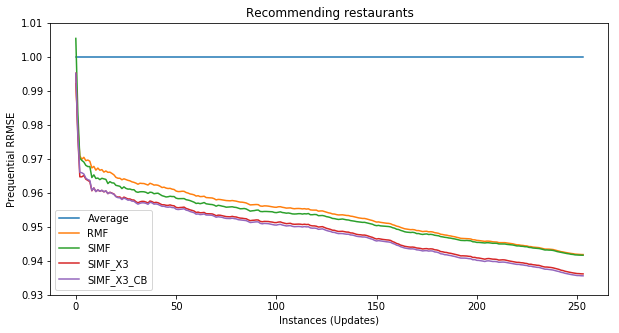

In [13]:
plot_results(results_restaurants, title='Recommending restaurants', ylim=(0.93, 1.01))

## Recommending *bars*

### Pick models to test

In [14]:
models = {
    'Average': Average(),
    'RMF': RMF(rank=25, max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF_X3': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF_X3_CB': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008, combine_bias=True),
}

r_ur = Relation(o_users, o_restaurants, build_sparse_matrix(train_ur), weight=1)
r_ub = Relation(o_users, o_bars, build_sparse_matrix(train_ub), weight=1)
r_uh = Relation(o_users, o_hotels, build_sparse_matrix(train_uh), weight=1)

Init random seed for consistent results.

In [15]:
np.random.seed(42)

### Initial factorization

In [16]:
models = pre_train_models(models, [r_ub, r_uh, r_ur], [test_ub, test_uh, test_ur])

Average
2019-04-15 14:52:49,610: Fitting the average model: bias=True, update=True
2019-04-15 14:52:49,666: Fit complete in 0.05404996871948242 seconds
Train error: RMSE:1.333169,  MAE:1.136226
Test error: RMSE:1.451131,  MAE:1.287774

RMF
2019-04-15 14:52:50,169: Initialization complete in 0.33546876907348633 seconds
2019-04-15 14:52:50,170: Factorizing (SGD) 1 relations: bias=True, max_iter=20, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 14:52:50,196: Factorization complete in 0.36247992515563965 seconds
Train error: RMSE:0.846718,  MAE:0.667718
Test error: RMSE:1.425863,  MAE:1.186614

SIMF
2019-04-15 14:52:50,665: Initialization complete in 0.36963510513305664 seconds
2019-04-15 14:52:50,666: Factorizing (SGD) 1 relations: bias=True, max_iter=20, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 14:52:50,718: Factorization complete in 0.4223001003265381 seconds
Train error: RMSE:0.847217,  MAE:0.646969
Test error: RMSE:1.425030,

### Stream evaluation

In [17]:
results_bars = evaluate_stream(models, [r_ub, r_uh, r_ur], [test_ub, test_uh, test_ur])

Starting streaming phase

Window:  0 1508623200 1508626800
Average window error: RMSE:1.485464,  RRMSE:1.000000
RMF window error: RMSE:1.497011,  RRMSE:1.007773
SIMF window error: RMSE:1.475094,  RRMSE:0.993019
SIMF_X3 window error: RMSE:1.470454,  RRMSE:0.989895
SIMF_X3_CB window error: RMSE:1.483862,  RRMSE:0.998922

Window:  25 1510783200 1510786800
Average window error: RMSE:1.442216,  RRMSE:1.000000
RMF window error: RMSE:1.468945,  RRMSE:1.018533
SIMF window error: RMSE:1.436569,  RRMSE:0.996084
SIMF_X3 window error: RMSE:1.430853,  RRMSE:0.992121
SIMF_X3_CB window error: RMSE:1.419123,  RRMSE:0.983988

Window:  50 1512943200 1512946800
Average window error: RMSE:1.369409,  RRMSE:1.000000
RMF window error: RMSE:1.357980,  RRMSE:0.991654
SIMF window error: RMSE:1.346889,  RRMSE:0.983555
SIMF_X3 window error: RMSE:1.349152,  RRMSE:0.985207
SIMF_X3_CB window error: RMSE:1.360592,  RRMSE:0.993561

Window:  75 1515103200 1515106800
Average window error: RMSE:1.333458,  RRMSE:1.000000


### Plot prequential RRMSE

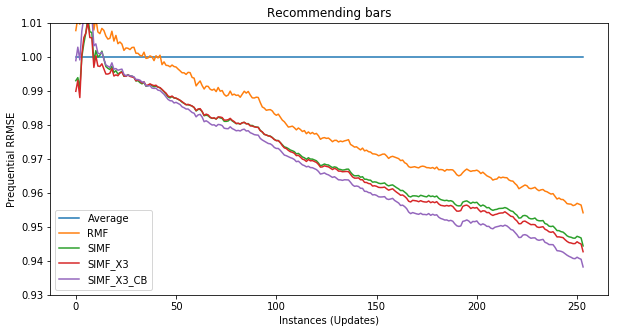

In [18]:
plot_results(results_bars, title='Recommending bars', ylim=(0.90, 1.01))